In [6]:
#pip install opencv-python


In [7]:
# MobileNetV2 + DCT/STFT/Wavelet/Learnable Frequency
# =====================
# Imports
# =====================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.signal import stft
import pywt
from tabulate import tabulate

In [8]:
# =====================
# Custom Transforms
# =====================
class DCTTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        dct = cv2.dct(np.float32(img))
        dct = cv2.resize(dct, (224, 224))
        dct = np.stack([dct, dct, dct], axis=-1)
        return torch.tensor(dct.transpose(2, 0, 1), dtype=torch.float32)

class STFTTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        f, t, Zxx = stft(img, nperseg=64)
        magnitude = np.abs(Zxx)
        magnitude = cv2.resize(magnitude, (224, 224))
        magnitude = np.stack([magnitude, magnitude, magnitude], axis=-1)
        return torch.tensor(magnitude.transpose(2, 0, 1), dtype=torch.float32)

class WaveletTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        coeffs2 = pywt.dwt2(img, 'haar')
        LL, (LH, HL, HH) = coeffs2
        wavelet_img = np.abs(LL)
        wavelet_img = cv2.resize(wavelet_img, (224, 224))
        wavelet_img = np.stack([wavelet_img, wavelet_img, wavelet_img], axis=-1)
        return torch.tensor(wavelet_img.transpose(2, 0, 1), dtype=torch.float32)

class LearnableFrequencyTransform(nn.Module):
    def __init__(self):
        super(LearnableFrequencyTransform, self).__init__()
        self.freq_filter = nn.Parameter(torch.randn(1, 224, 224))

    def forward(self, img):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (224, 224))
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        filtered = img_tensor * self.freq_filter
        filtered = filtered.squeeze(0).detach().numpy()
        filtered = np.stack([filtered, filtered, filtered], axis=-1)
        return torch.tensor(filtered.transpose(2, 0, 1), dtype=torch.float32)

In [9]:
# =====================
# CONFIGURATION
# =====================
config = {
    "epochs": 50,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 7,
    "dropout": 0.4,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
    "save_dir": r"F:\final project\Capstone Prj\MNV2",
    "transform_type": "learnable",  # options: dct, stft, wavelet, learnable
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}
os.makedirs(config["save_dir"], exist_ok=True)

In [10]:

# =====================
# Select Transform
# =====================
if config["transform_type"] == "dct":
    transform_fn = DCTTransform()
elif config["transform_type"] == "stft":
    transform_fn = STFTTransform()
elif config["transform_type"] == "wavelet":
    transform_fn = WaveletTransform()
elif config["transform_type"] == "learnable":
    transform_fn = LearnableFrequencyTransform()
else:
    raise ValueError("Invalid transform_type in config")

train_transforms = transforms.Compose([
    transform_fn,
    transforms.Normalize([0.5], [0.5])
])
test_transforms = transforms.Compose([
    transform_fn,
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(root=config["train_dir"], transform=train_transforms)
val_dataset = datasets.ImageFolder(root=config["val_dir"], transform=test_transforms)
test_dataset = datasets.ImageFolder(root=config["test_dir"], transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# =====================
# Model: MobileNetV2
# =====================
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(config["dropout"]),
    nn.Linear(model.last_channel, config["num_classes"])
)
model = model.to(config["device"])

# =====================
# Loss & Optimizer
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])


f:\final project\Capstone Prj\Capstone\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\final project\Capstone Prj\Capstone\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# =====================
# Training Function
# =====================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_loss = float("inf")
    patience_counter = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            save_path = os.path.join(config["save_dir"], "mobilenetv2_freq_best.pth")
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Plot curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend(), plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend(), plt.title("Accuracy Curve")
    plt.show()

Epoch 1/50: 100%|██████████| 393/393 [02:38<00:00,  2.48it/s]


Epoch 1/50 - Train Loss: 1.1224, Train Acc: 0.6179, Val Loss: 1.0547, Val Acc: 0.6265


Epoch 2/50: 100%|██████████| 393/393 [02:41<00:00,  2.44it/s]


Epoch 2/50 - Train Loss: 1.0574, Train Acc: 0.6295, Val Loss: 1.0713, Val Acc: 0.6205


Epoch 3/50: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s]


Epoch 3/50 - Train Loss: 1.0403, Train Acc: 0.6329, Val Loss: 1.0805, Val Acc: 0.6265


Epoch 4/50: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s]


Epoch 4/50 - Train Loss: 1.0227, Train Acc: 0.6393, Val Loss: 1.0739, Val Acc: 0.6291


Epoch 5/50: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s]


Epoch 5/50 - Train Loss: 1.0076, Train Acc: 0.6430, Val Loss: 1.0552, Val Acc: 0.6246


Epoch 6/50: 100%|██████████| 393/393 [02:39<00:00,  2.46it/s]


Epoch 6/50 - Train Loss: 0.9893, Train Acc: 0.6464, Val Loss: 1.0367, Val Acc: 0.6343


Epoch 7/50: 100%|██████████| 393/393 [02:40<00:00,  2.44it/s]


Epoch 7/50 - Train Loss: 0.9675, Train Acc: 0.6492, Val Loss: 1.0415, Val Acc: 0.6451


Epoch 8/50: 100%|██████████| 393/393 [02:41<00:00,  2.44it/s]


Epoch 8/50 - Train Loss: 0.9533, Train Acc: 0.6537, Val Loss: 1.0769, Val Acc: 0.6313


Epoch 9/50: 100%|██████████| 393/393 [02:40<00:00,  2.45it/s]


Epoch 9/50 - Train Loss: 0.9330, Train Acc: 0.6541, Val Loss: 1.0712, Val Acc: 0.6224


Epoch 10/50: 100%|██████████| 393/393 [02:41<00:00,  2.43it/s]


Epoch 10/50 - Train Loss: 0.9071, Train Acc: 0.6632, Val Loss: 1.0547, Val Acc: 0.6380


Epoch 11/50: 100%|██████████| 393/393 [02:42<00:00,  2.41it/s]


Epoch 11/50 - Train Loss: 0.8777, Train Acc: 0.6682, Val Loss: 1.0743, Val Acc: 0.6120


Epoch 12/50: 100%|██████████| 393/393 [02:42<00:00,  2.41it/s]


Epoch 12/50 - Train Loss: 0.8504, Train Acc: 0.6747, Val Loss: 1.0988, Val Acc: 0.6406


Epoch 13/50: 100%|██████████| 393/393 [02:43<00:00,  2.40it/s]


Epoch 13/50 - Train Loss: 0.8078, Train Acc: 0.6921, Val Loss: 1.0977, Val Acc: 0.6101
Early stopping triggered!


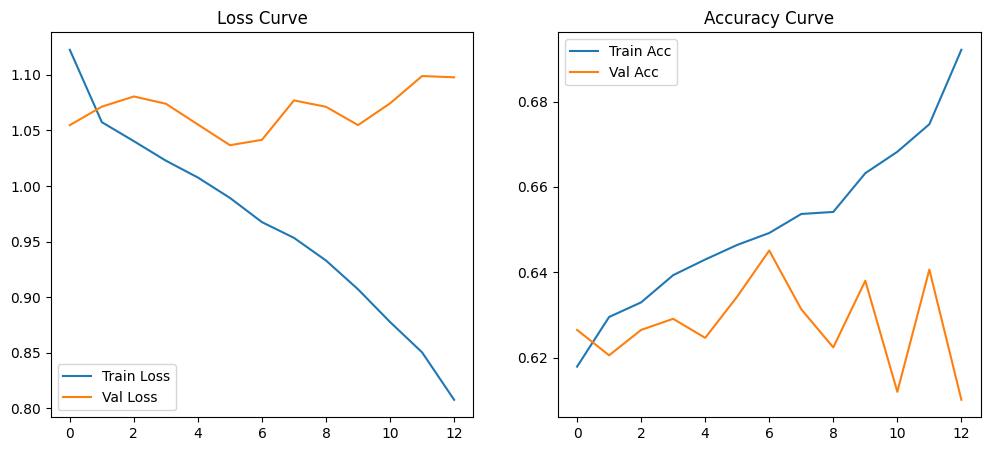


=== Evaluation Results ===
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.6354 |
+-----------+---------+
| Precision |  0.5215 |
+-----------+---------+
| Recall    |  0.6354 |
+-----------+---------+
| F1 Score  |  0.5612 |
+-----------+---------+


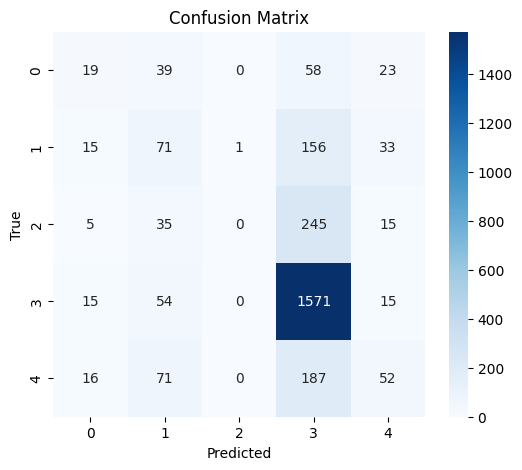

In [12]:
# =====================
# Evaluation Function
# =====================
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print results in table format
    metrics_table = [
        ["Accuracy", f"{acc:.4f}"],
        ["Precision", f"{prec:.4f}"],
        ["Recall", f"{rec:.4f}"],
        ["F1 Score", f"{f1:.4f}"]
    ]
    print("\n=== Evaluation Results ===")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

    # Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_loader.dataset.classes,
                yticklabels=test_loader.dataset.classes)
    plt.xlabel("Predicted"), plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# =====================
# Run
# =====================
train_model(model, train_loader, val_loader, criterion, optimizer,
            config["epochs"], config["early_stopping_patience"])

# Load best model for evaluation
best_model_path = os.path.join(config["save_dir"], "mobilenetv2_freq_best.pth")
model.load_state_dict(torch.load(best_model_path, map_location=config["device"]))
evaluate_model(model, test_loader)
